In [1]:
%matplotlib inline


# A simple PyDESeq2 workflow

In this example, we show how to perform a simple differential expression analysis on bulk
RNAseq data, using PyDESeq2.
    :depth: 3

We start by importing required packages and setting up an optional path to save results.


In [2]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "output_files/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

## Data loading

To perform differential expression analysis (DEA), PyDESeq2 requires two types of
inputs:

  * A count matrix of shape 'number of samples' x 'number of genes', containing
    read counts (non-negative integers),
  * Metadata (or "column" data) of shape 'number of samples' x
    'number of variables', containing sample annotations that will be used
    to split the data in cohorts.

Both should be provided as [pandas dataframes](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

.. currentmodule:: pydeseq2

To illustrate the required data format, we load a synthetic example dataset that may be
obtained through PyDESeq2's API using :func:`utils.load_example_data`.
You may replace it with your own dataset.



In [3]:
counts_df = load_example_data(
    modality="raw_counts",
    dataset="synthetic",
    debug=False,
)

metadata = load_example_data(
    modality="metadata",
    dataset="synthetic",
    debug=False,
)

print(counts_df)

           gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  \
sample1       12     21      4    130     18      0     16     54     49   
sample2        1     44      2     63     11     10     70     32     57   
sample3        4      4     11    180     21      3     28     34     65   
sample4        1     10      2    100     44      9     28     16     33   
sample5        1     11      6    135     16      2     32     29     31   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
sample96       7     26      3     67     11      4     41     44     54   
sample97       1     14      3     71     33      5     19     42     25   
sample98      10     36      2     72     11      2     66     27     16   
sample99      18     14      3     66     53     11     32     19     79   
sample100     21      9      3     42     13     13     19     78     30   

           gene10  
sample1         3  
sample2         9  
sample3         2  
sample4

In [4]:
print(metadata)

          condition group
sample1           A     X
sample2           A     Y
sample3           A     X
sample4           A     Y
sample5           A     X
...             ...   ...
sample96          B     Y
sample97          B     X
sample98          B     Y
sample99          B     X
sample100         B     Y

[100 rows x 2 columns]


In this example, the metadata data contains two columns, ``condition`` and ``group``,
representing two types of bi-level annotations. In the first part, we will only use the
``condition`` factor. Later on, we'll see how to use both the `condition` and the
``group`` factors in our analysis (see `multifactor_ref`).



### Data filtering

Before proceeding with DEA, it is good practice to preprocess your data, e.g. to remove
samples for which annotations are missing and exclude genes with very low levels of
expression. This is not necessary in the case of our synthetic data, but don't forget
this step if you are using real data. To this end you can use the code below.

We start by removing samples for which ``condition`` is ``NaN``. If you are using
another dataset, do not forget to change "condition" for the column of ``metadata``
you wish to use as a design factor in your analysis.



In [5]:
samples_to_keep = ~metadata.condition.isna()
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

<div class="alert alert-info"><h4>Note</h4><p>In the case where the design factor contains ``NaN`` entries, PyDESeq2 will throw an
  error when intializing a :class:`DeseqDataSet <dds.DeseqDataSet>`.</p></div>



Next, we filter out genes that have less than 10 read counts in total. Note again that
there are no such genes in this synthetic dataset.



In [6]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
counts_df

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10
sample1,12,21,4,130,18,0,16,54,49,3
sample2,1,44,2,63,11,10,70,32,57,9
sample3,4,4,11,180,21,3,28,34,65,2
sample4,1,10,2,100,44,9,28,16,33,9
sample5,1,11,6,135,16,2,32,29,31,5
...,...,...,...,...,...,...,...,...,...,...
sample96,7,26,3,67,11,4,41,44,54,1
sample97,1,14,3,71,33,5,19,42,25,4
sample98,10,36,2,72,11,2,66,27,16,9
sample99,18,14,3,66,53,11,32,19,79,11


Now that we have loaded and filtered our data, we may proceed with the differential
analysis.



## Single factor analysis

In this first analysis, we ignore the ``group`` variable and use the ``condition``
column as our design factor. That is, we compare gene expressions of samples that have
``condition B`` to those that have ``condition A``.




.. currentmodule:: pydeseq2.dds

### Read counts modeling with the :class:`DeseqDataSet` class

We start by creating a :class:`DeseqDataSet`
object from the count and metadata data.
A :class:`DeseqDataSet` fits dispersion and
log-fold change (LFC) parameters from the data, and stores them.




In [7]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~condition",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

A :class:`DeseqDataSet` has two mandatory
arguments: a ``counts`` and a ``metadata`` dataframe, like the ones we've loaded in the
first part of this tutorial.

Next, we should specify a ``design``, i.e. a Wilkinson formula that describes the
design, or directly a design matrix. Here we provide a formula, which is a string
that [formulaic](https://github.com/matthewwardrop/formulaic) should be able to
parse.

<div class="alert alert-info"><h4>Note</h4><p>The ``"condition"`` factor in ``design`` corresponds to a column
  from the ``metadata`` dataframe we loaded earlier.
  You might need to change it according to your own dataset.</p></div>

Several other arguments may be optionally specified (see the :doc:`API documentation
</api/docstrings/pydeseq2.dds.DeseqDataSet>`).
Among those, the ``refit_cooks`` argument (set to ``True`` by default), controls
whether Cooks outlier should be refitted (which is advised, in general) and ``n_cpus``
sets the number of CPUs to use for computation. Here, we use 8 threads. Feel free to
adapt this to your setup or to set to ``None`` to use all available CPUs.

<div class="alert alert-info"><h4>Note</h4><p>In the case of the provided synthetic data, there won't be any Cooks outliers.</p></div>

Once a :class:`DeseqDataSet` was initialized,
we may run the :meth:`deseq2() <DeseqDataSet.deseq2>` method
to fit dispersions and LFCs.





In [8]:
dds.deseq2()


if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "wb") as f:
        pkl.dump(dds, f)

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.07 seconds.

Fitting dispersion trend curve...
... done in 0.18 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



The :class:`DeseqDataSet` class extends the
:class:`AnnData <anndata.AnnData>`
class.



In [9]:
print(dds)

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'


Hence, parameters are stored according to the :class:`AnnData <anndata.AnnData>` data
structure, with key-based data fields. In particular,

- ``X`` stores the count data,
- ``obs`` stores design factors,
- ``obsm`` stores sample-level data, such as ``"design_matrix"`` and
  ``"size_factors"``,
- ``varm`` stores gene-level data, such as ``"dispersions"`` and ``"LFC"``.


As an example, here is how we would access dispersions and LFCs
(in natural log scale):



In [10]:
print(dds.varm["dispersions"])

[0.90859762 0.21372942 0.83725482 0.1612233  0.24840696 0.97365193
 0.23259225 0.19876404 0.1865093  0.63189179]


In [11]:
print(dds.varm["LFC"])

        Intercept  condition[T.B]
gene1    1.891808        0.438450
gene2    2.851521        0.373414
gene3    1.787780       -0.438644
gene4    4.741958       -0.285614
gene5    3.077797        0.403446
gene6    1.678536        0.001010
gene7    3.290975        0.093142
gene8    3.785129       -0.187605
gene9    3.682882       -0.147442
gene10   2.300515        0.267562


.. currentmodule:: pydeseq2.ds

### Statistical analysis with the :class:`DeseqStats` class

Now that dispersions and LFCs were fitted, we may proceed with statistical tests to
compute p-values and adjusted p-values for differential expresion. This is the role of
the :class:`DeseqStats` class. It has two mandatory arguments:

- ``dds``, which should be a *fitted* :class:`DeseqDataSet <pydeseq2.dds.DeseqDataSet>`
  object,
- ``contrast``, which is a list of three strings of the form
  ``["variable", "tested_level", "control_level"]``, or directly a contrast vector.




In [12]:
ds = DeseqStats(dds, contrast=["condition", "B", "A"], inference=inference)

It also has a set of optional keyword arguments (see the :doc:`API documentation
</api/docstrings/pydeseq2.ds.DeseqStats>`), among which:

- ``alpha``: the p-value and adjusted p-value significance threshold (``0.05``
  by default),
- ``cooks_filter``: whether to filter p-values based on cooks outliers
  (``True`` by default),
- ``independent_filter``: whether to perform independent filtering to correct
  p-value trends (``True`` by default).

In the `section on multifactor analysis<multifactor_ref>`, we will also see how
to use the ``contrast`` argument to specify according to which variable samples should
be compared.




#### Wald test

PyDESeq2 computes p-values using Wald tests. This can be done using the
:meth:`summary() <DeseqStats.summary>` method, which runs the whole statistical
analysis, cooks filtering and multiple testing adjustement included.



In [13]:
ds.summary()

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "ds.pkl"), "wb") as f:
        pkl.dump(ds, f)

Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541318        0.632550  0.292819  2.160211  0.030756  0.064153
gene2    21.281240        0.538722  0.147482  3.652791  0.000259  0.001297
gene3     5.010124       -0.632830  0.295238 -2.143457  0.032076  0.064153
gene4   100.517967       -0.412054  0.119417 -3.450546  0.000559  0.001865
gene5    27.142450        0.582049  0.154296  3.772290  0.000162  0.001297
gene6     5.413043        0.001457  0.310312  0.004697  0.996253  0.996253
gene7    28.294025        0.134375  0.149231  0.900450  0.367881  0.408756
gene8    40.358341       -0.270656  0.136396 -1.984337  0.047218  0.078697
gene9    37.166183       -0.212715  0.133240 -1.596477  0.110382  0.143145
gene10   11.589326        0.386011  0.244587  1.578217  0.114516  0.143145


Running Wald tests...
... done in 0.03 seconds.



The results are then stored in the ``results_df`` attribute (``ds.results_df``).



#### Optional: threshold-based tests

The user can specify a (log2) log fold change under the null hypothesis and an
alternative hypothesis to re-compute Wald statistics and p-values.
The alternative hypothesis corresponds to what the user wants to find rather than the
null hypothesis. It can take one of the values
``["greaterAbs", "lessAbs", "greater", "less"]``.



Running Wald tests...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541318        0.632550  0.292819  1.818703  0.068957  0.142228
gene2    21.281240        0.538722  0.147482  2.974743  0.002932  0.014662
gene3     5.010124       -0.632830  0.295238 -1.804747  0.071114  0.142228
gene4   100.517967       -0.412054  0.119417 -2.613145  0.008971  0.029904
gene5    27.142450        0.582049  0.154296  3.124185  0.001783  0.014662
gene6     5.413043        0.001457  0.310312  0.000000  1.000000  1.000000
gene7    28.294025        0.134375  0.149231  0.230349  0.817821  0.908690
gene8    40.358341       -0.270656  0.136396 -1.251179  0.210869  0.346081
gene9    37.166183       -0.212715  0.133240 -0.845952  0.397580  0.496975
gene10   11.589326        0.386011  0.244587  1.169364  0.242257  0.346081


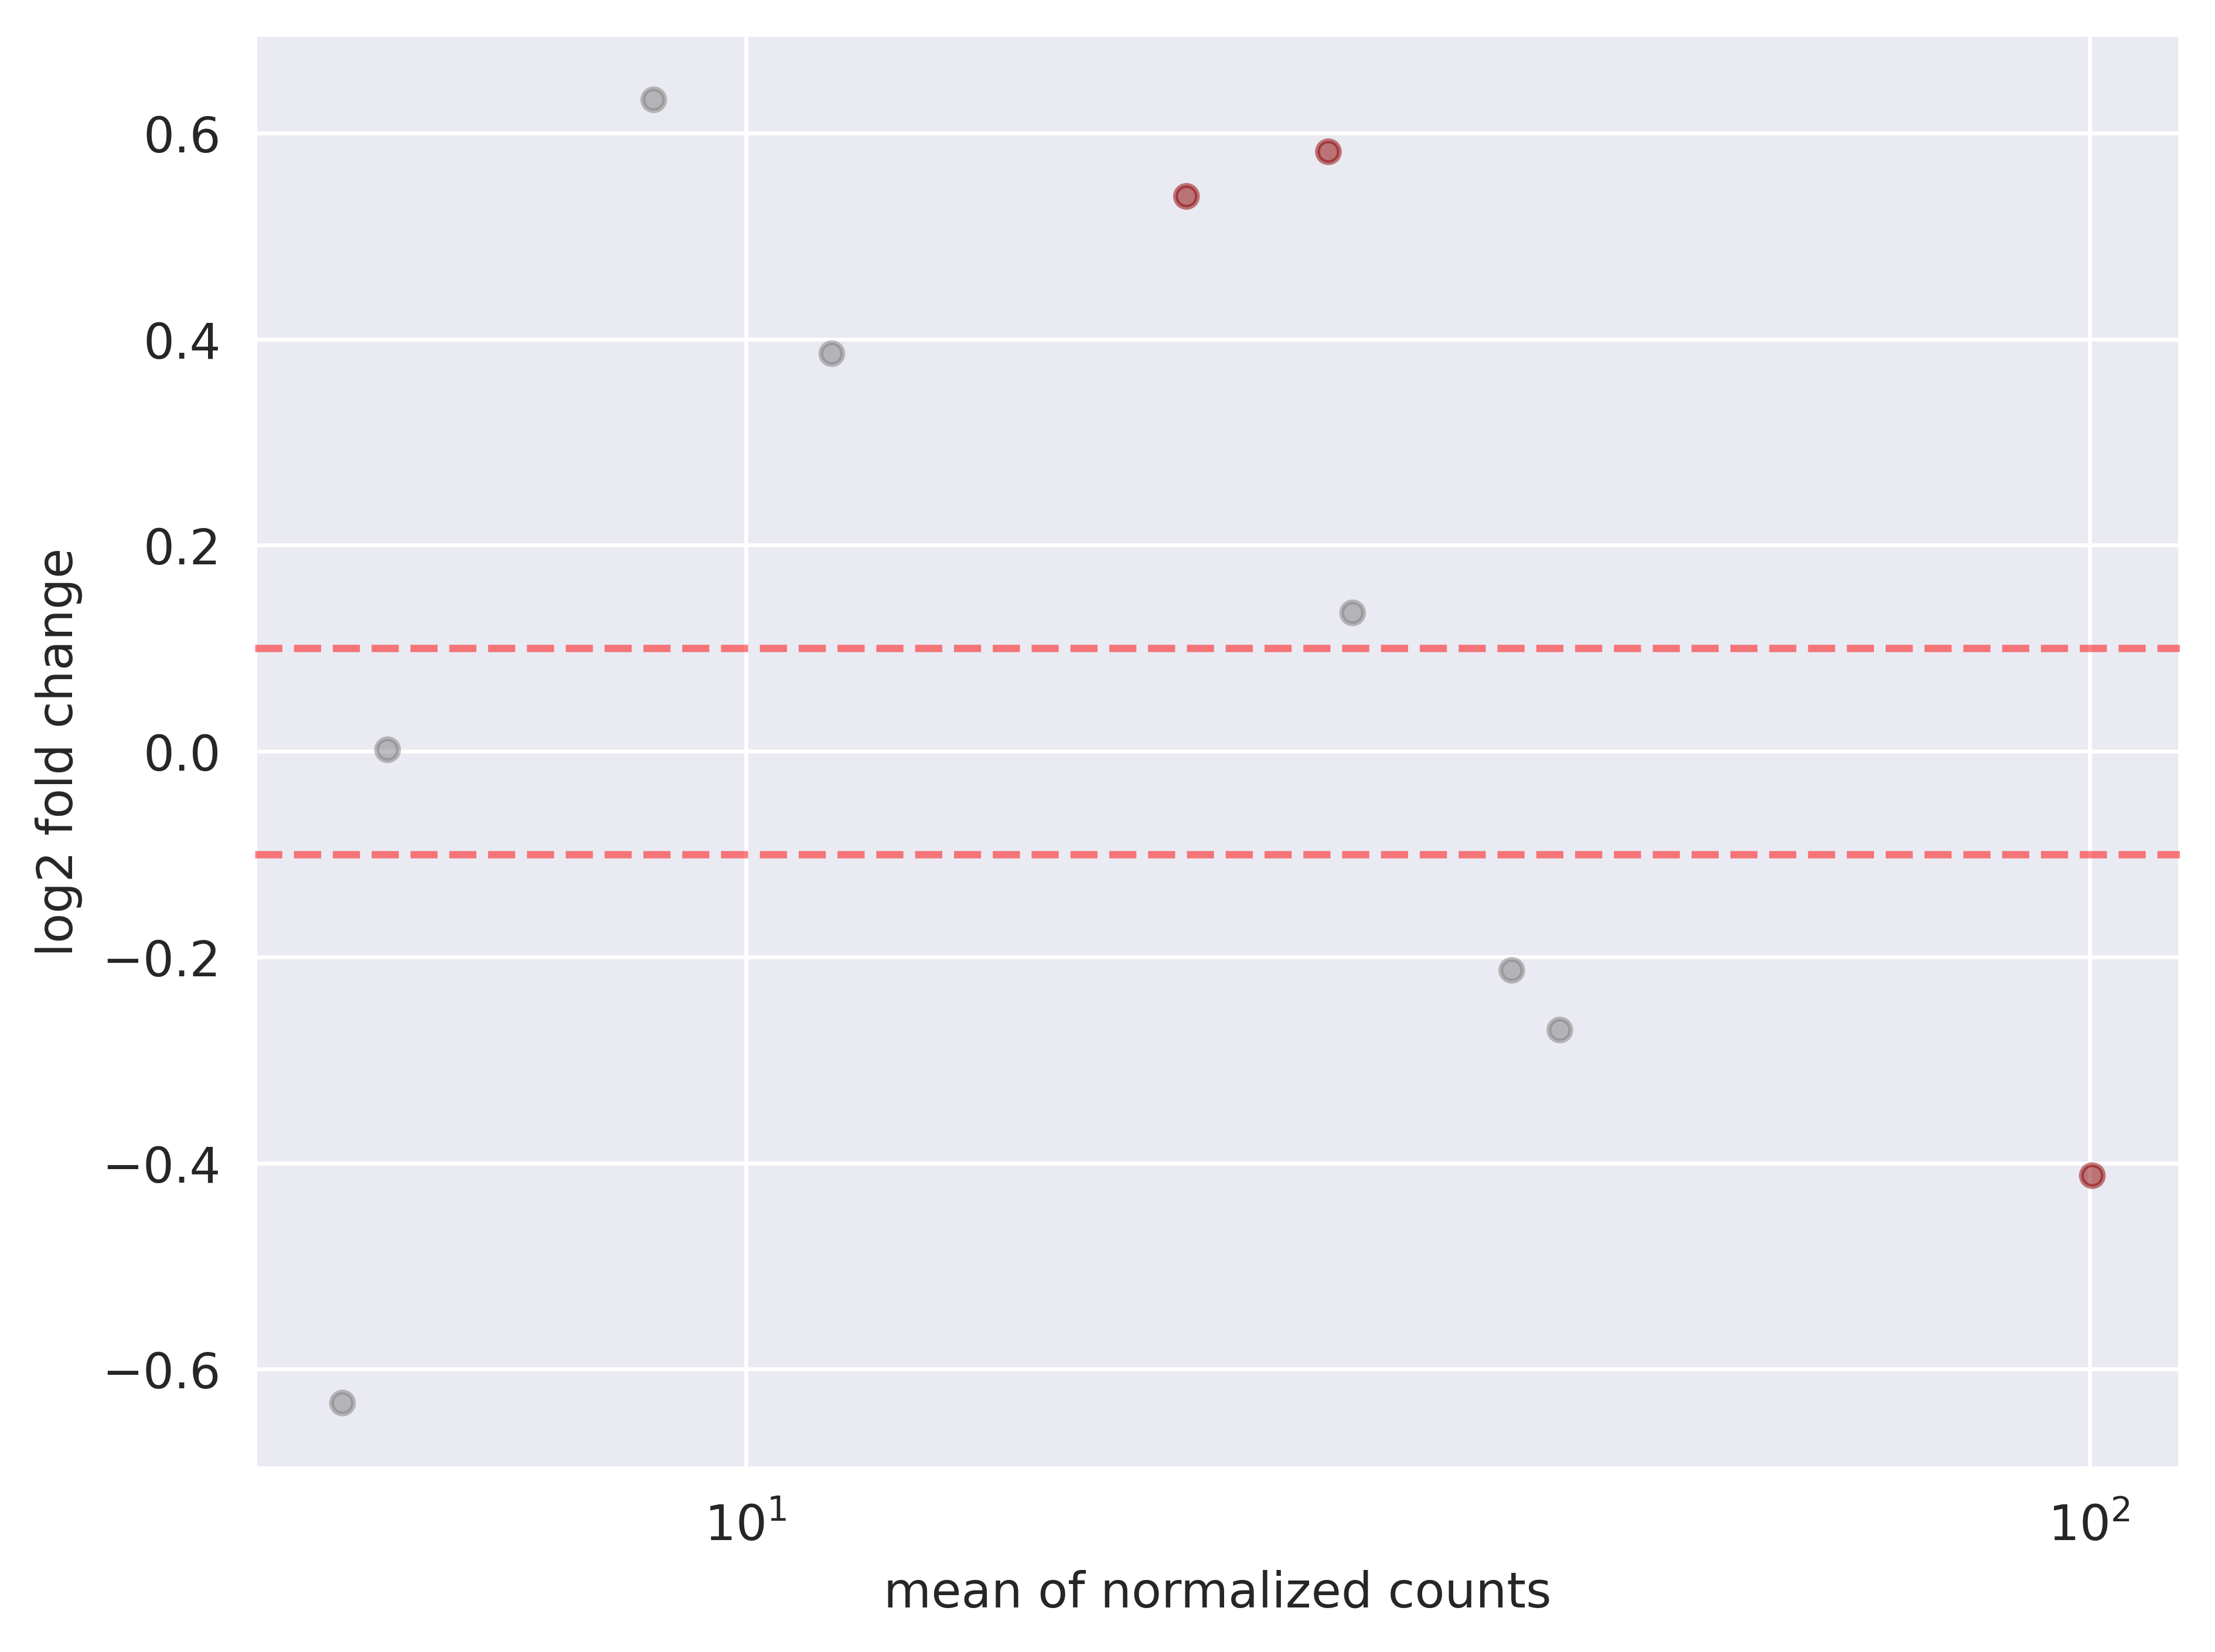

In [14]:
ds.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
ds.plot_MA(s=20)

#### LFC shrinkage

For visualization or post-processing purposes, it might be suitable to perform
LFC shrinkage. This is implemented by the :meth:`lfc_shrink() <DeseqStats.lfc_shrink>`
method, which takes as argument the name of the coefficient to shrink (i.e., the name
of one of the columns of the design matrix ``dds.obsm["design_matrix"]``).
For instance, to shrink the LFCs of the ``condition B`` samples, we would run:



In [15]:
ds.lfc_shrink(coeff="condition[T.B]")

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "shrunk_results.pkl"), "wb") as f:
        pkl.dump(ds, f)

Shrunk log2 fold change & Wald test p-value: condition[T.B]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541318        0.401712  0.297592  1.818703  0.068957  0.142228
gene2    21.281240        0.482387  0.148677  2.974743  0.002932  0.014662
gene3     5.010124       -0.395955  0.300810 -1.804747  0.071114  0.142228
gene4   100.517967       -0.373797  0.119489 -2.613145  0.008971  0.029904
gene5    27.142450        0.521830  0.155787  3.124185  0.001783  0.014662
gene6     5.413043        0.000715  0.239158  0.000000  1.000000  1.000000
gene7    28.294025        0.103697  0.140902  0.230349  0.817821  0.908690
gene8    40.358341       -0.226390  0.133474 -1.251179  0.210869  0.346081
gene9    37.166183       -0.175941  0.129137 -0.845952  0.397580  0.496975
gene10   11.589326        0.239860  0.231979  1.169364  0.242257  0.346081


Fitting MAP LFCs...
... done in 0.02 seconds.



<div class="alert alert-info"><h4>Note</h4><p>Running :meth:`lfc_shrink() <DeseqStats.lfc_shrink>` will overwrite a
  :class:`DeseqStats`' log fold changes (and standard errors) with shrunk values.
  This can be checked using the ``shrunk_LFCs`` flag.</p></div>




In [16]:
print(ds.shrunk_LFCs)  # Will be True only if lfc_shrink() was run.

True



## Multifactor analysis

.. currentmodule:: pydeseq2.dds

So far, we have only used the ``condition`` column of ``metadata``, which divides
samples between conditions ``A`` and ``B``. Yet, ``metadata`` contains second
column, which separates samples according to ``group`` ``X`` and ``Y``.



In [17]:
print(metadata)

          condition group
sample1           A     X
sample2           A     Y
sample3           A     X
sample4           A     Y
sample5           A     X
...             ...   ...
sample96          B     Y
sample97          B     X
sample98          B     Y
sample99          B     X
sample100         B     Y

[100 rows x 2 columns]


The goal of multifactor analysis is to use *both* variables to fit LFCs.

### Read counts modeling

To perform multifactor analysis with PyDESeq2, we start by inializing a
:class:`DeseqDataSet` as previously, but we provide several variables we would like
to use in the ``design`` argument.




In [18]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~group + condition",
    refit_cooks=True,
    inference=inference,
)

As for the single-factor analysis, we fit dispersions and LFCs using the
:meth:`deseq2() <DeseqDataSet.deseq2>` method.



In [19]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.06 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.13 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Now, if we print log fold changes, we will have two columns in addition to the
intercept: one corresponding to the ``group`` variable, and the other to ``condition``.



In [20]:
print(dds.varm["LFC"])

        Intercept  group[T.Y]  condition[T.B]
gene1    1.560313    0.525572        0.507012
gene2    2.812255    0.079230        0.371026
gene3    2.059577   -0.602606       -0.467002
gene4    4.919837   -0.385185       -0.293518
gene5    2.973802    0.194078        0.407582
gene6    1.846061   -0.352410       -0.013510
gene7    3.235957    0.106753        0.093663
gene8    3.640461    0.270823       -0.188268
gene9    3.645333    0.074474       -0.148345
gene10   2.136676    0.303014        0.269999


.. currentmodule:: pydeseq2.ds

### Statistical analysis

P-values are computed as earlier from a :class:`DeseqStats` object with the
:meth:`summary() <DeseqStats.summary>` method. The ``contrast`` argument will allow us
to determines which variable we want to obtain LFCs and pvalues for.
It is a list of three strings of the form
``["variable", "tested level", "reference level"]``
As an example, to compare the condition B to the condition A, we set
``contrast=["condition", "B", "A"]``.




In [21]:
ds_B_vs_A = DeseqStats(dds, contrast=["condition", "B", "A"], inference=inference)

Let us fit p-values:




In [22]:
ds_B_vs_A.summary()

Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541318        0.731464  0.286252  2.555313  0.010609  0.026523
gene2    21.281240        0.535278  0.149822  3.572768  0.000353  0.001177
gene3     5.010124       -0.673742  0.287400 -2.344263  0.019065  0.038129
gene4   100.517967       -0.423456  0.106548 -3.974320  0.000071  0.000592
gene5    27.142450        0.588016  0.152755  3.849404  0.000118  0.000592
gene6     5.413043       -0.019490  0.307845 -0.063312  0.949518  0.949518
gene7    28.294025        0.135127  0.149260  0.905313  0.365300  0.405889
gene8    40.358341       -0.271613  0.131238 -2.069625  0.038487  0.064146
gene9    37.166183       -0.214017  0.132974 -1.609470  0.107514  0.139903
gene10   11.589326        0.389526  0.245045  1.589612  0.111922  0.139903


Running Wald tests...
... done in 0.03 seconds.



As we can see, although we are comparing the same cohorts (condition B vs A), the
results differ from the `single-factor analysis <wald_ref>`. This is because the
model uses information from both the ``condition`` and ``group`` variables.

Let us now evaluate differential expression according to group Y vs X. To do so,
we create a new :class:`DeseqStats` from the same
:class:`DeseqDataSet <pydeseq2.dds.DeseqDataSet>`
with ``contrast=["group", "Y", "X"]``, and run the analysis again.



In [23]:
ds_Y_vs_X = DeseqStats(dds, contrast=["group", "Y", "X"], inference=inference)
ds_Y_vs_X.summary()

Running Wald tests...
... done in 0.02 seconds.



Log2 fold change & Wald test p-value: group Y vs X
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
gene1     8.541318        0.758240  0.286305  2.648361  8.088318e-03  0.020221
gene2    21.281240        0.114304  0.149769  0.763203  4.453426e-01  0.445343
gene3     5.010124       -0.869376  0.287517 -3.023742  2.496690e-03  0.009703
gene4   100.517967       -0.555704  0.106549 -5.215477  1.833448e-07  0.000002
gene5    27.142450        0.279995  0.152728  1.833291  6.675931e-02  0.124094
gene6     5.413043       -0.508421  0.307951 -1.650981  9.874252e-02  0.141061
gene7    28.294025        0.154012  0.149265  1.031805  3.021633e-01  0.377704
gene8    40.358341        0.390716  0.131245  2.976989  2.910945e-03  0.009703
gene9    37.166183        0.107443  0.132966  0.808047  4.190635e-01  0.445343
gene10   11.589326        0.437157  0.245071  1.783800  7.445613e-02  0.124094


#### LFC shrinkage (multifactor)

In a multifactor setting, LFC shrinkage works as in the single-factor case, but will
only shrink the LFCs of a :class:`DeseqStats` object based on its
``contrast`` argument.



In [24]:
ds_B_vs_A.lfc_shrink(coeff="condition[T.B]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.B]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541318        0.526883  0.299277  2.555313  0.010609  0.026523
gene2    21.281240        0.479377  0.150832  3.572768  0.000353  0.001177
gene3     5.010124       -0.463476  0.296140 -2.344263  0.019065  0.038129
gene4   100.517967       -0.394586  0.106649 -3.974320  0.000071  0.000592
gene5    27.142450        0.531654  0.154059  3.849404  0.000118  0.000592
gene6     5.413043       -0.008636  0.241564 -0.063312  0.949518  0.949518
gene7    28.294025        0.106792  0.141626  0.905313  0.365300  0.405889
gene8    40.358341       -0.233339  0.128813 -2.069625  0.038487  0.064146
gene9    37.166183       -0.180071  0.129232 -1.609470  0.107514  0.139903
gene10   11.589326        0.251338  0.233227  1.589612  0.111922  0.139903


... done in 0.02 seconds.

